In [11]:
%matplotlib inline
import os
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
#from sympy import *
#from qm import*
import math
#from random import shuffle
import random
import time
import csv

plt.rcParams['figure.figsize'] = (10,7)

import subprocess
import glob
import itertools

In [12]:
!pip freeze

adblockparser==0.7
AdvancedHTTPServer==2.2.0
aiocmd==0.1.2
aioconsole==0.3.1
aiodns==2.0.0
aiofiles==0.6.0
aiohttp==3.7.4
aiomultiprocess==0.8.0
aiosqlite==0.16.1
aiowinreg==0.0.3
alembic==1.7.1.dev0
altgraph==0.17.2
aniso8601==9.0.1
anyio==3.3.4
apispec==3.3.1
apispec-webframeworks==0.5.2
appdirs==1.4.4
argon2-cffi==21.1.0
asciitree==0.3.3
asgiref==3.4.1
asn1crypto==1.4.0
async-timeout==3.0.1
asysocks==0.0.2
attrs==20.3.0
autobahn==17.10.1
Automat==20.2.0
Babel==2.8.0
backcall==0.2.0
backoff==1.10.0
basemap==1.2.1
bcrypt==3.2.0
beautifulsoup4==4.10.0
bidict==0.21.3
binwalk==2.3.2
bleach==4.1.0
blinker==1.4
bluepy==1.3.0
boltons==19.1.0
bottle==0.12.19
Brlapi==0.8.3
Brotli==1.0.9
cairocffi==1.2.0
cbor==1.0.0
censys==2.0.9
certifi==2020.6.20
cffi==1.15.0
chardet==4.0.0
cheroot==8.5.2+ds1
CherryPy==18.6.1
cherrypy-cors==1.6
cli-helpers==2.2.0
click==7.1.2
click-plugins==1.1.1
colorama==0.4.4
commonmark==0.9.1
configobj==5.0.6
constantly==15.1.0
crackmapexec==5.1.7.dev0
crit==0.0.1
crypto

In [13]:
##########################  
# Essa funcao é definitiva, ela das três formas é a mais eficiente, 
def novo_shuffle(numero_estados, tamanho_espaco_busca):
    espaco_busca = []
    for i in range (2**tamanho_espaco_busca):
        espaco_busca.append(bin(i)[2:].zfill(tamanho_espaco_busca))
    lista_remover = list(espaco_busca)
    nova_atrib = []
    for i in range(numero_estados):
        valor = random.choice(lista_remover)
        lista_remover.remove(valor)
        nova_atrib.append(valor)
    
    return nova_atrib

In [14]:
def correspondente(palavra1, palavra2, tam_space):
    espaco_busca = []
    for i in range (2**tam_space):
        espaco_busca.append(bin(i)[2:].zfill(tam_space))
    espaco_aleatorio = palavra2
    #print(palavra1)
    #print(palavra2)
    for i in range(len(espaco_busca)):
        if palavra1 == espaco_busca[i]:
            return str(espaco_aleatorio[i])

In [15]:
def simplifica_maquina(filename):
    teste = subprocess.run(['./espresso',filename],stdout=subprocess.PIPE,universal_newlines=True)
    saida = teste.stdout
    a = open(filename,'w')
    a.write(saida)
    a.close()

In [16]:
def leitura(filename):
    nova = open(filename,'r')
    line_char = nova.readlines()
    custo_nova = int(line_char[2][3:])
    nova.close()
    return custo_nova

In [17]:
def troca_maquina(newfilename, bestfilename):
    nova = open(newfilename,'r')
    melhor = open(bestfilename,'w')
    nova_lista = nova.readlines()
    for i in range(len(nova_lista)):
        melhor.write(str(nova_lista[i]))
    nova.close()
    melhor.close()

In [18]:
def calculo_custo(filename, entrada_input, saida_output, numero_estados):
    transicoes_nova = leitura(filename)
    area = transicoes_nova*(2*entrada_input + 3*(np.log2(numero_estados)) + saida_output)
    return area

In [19]:
def resfriamento_simulado(casefilename, temperatura, vizinhos):
    #####################################################################
    # Faz a leitura do arquivo KISS2 e prepara as variáveis globais
    l = []
    entrada = []
    lista_entradas = []
    saida = []
    lista_saidas = []

    estados = []

    atual = []
    atual_inteiro = []
    atual_convertido = []

    proximo = []
    proximo_inteiro = []
    proximo_convertido = []

    espaco_aleatorio = []

    comprimento_input = 0
    comprimento_output = 0
    line_char = []
    msf_pronta = []

    tamanho_espaco_busca = 0
    
    temp = open('msfs/' + casefilename +'.kiss2')

    line_char = temp.readlines()
    #print(line_char)

    estados = line_char[4:5]
    estados_convertido = int(estados[0].split()[1])

    #define o tamanho do espaço de busca basedado no valor entregue pelo arquivo

    tamanho_espaco_busca = math.ceil(np.log2(estados_convertido))

    entrada_input = int(line_char[1][3:])
    saida_output = int(line_char[2][3:])
    numero_estados = int(line_char[4][3:])

    #msf_pronta = []

    l = line_char[5:]
    #print(l)
    
    for i in range(len(l)):
        entrada = l[i].split()[0]
        lista_entradas.append(entrada)
    
        atual = l[i].split()[1]
        proximo = l[i].split()[2]
        saida = l[i].split()[3]
        lista_saidas.append(saida)
    
        atual_inteiro = int(''.join([i for i in atual if i.isdigit()]))
        #print(atual)
        proximo_inteiro = int(''.join([i for i in proximo if i.isdigit()]))

        atual_convertido.append(bin(atual_inteiro)[2:].zfill(tamanho_espaco_busca))
        #atual_binario = atual_convertido[i]
        proximo_convertido.append(bin(proximo_inteiro)[2:].zfill(tamanho_espaco_busca))
        #proximo_binario = proximo_convertido[i]
        linha = str(lista_entradas[i])+str(atual_convertido[i])+' '+str(proximo_convertido[i])+str(lista_saidas[i])
        msf_pronta.append(linha)
        #print(msf_pronta[i])
    
    #msf_pronta.append('.e')
    #print(atual_convertido)
    comprimento_input = str(len(lista_entradas[0])+len(atual_convertido[0]))
    comprimento_output = str(len(proximo_convertido[0])+len(lista_saidas[0]))
    #print(comprimento_input)

    d = open('melhor.pla','w')
    #d.write('\n')
    d.write('.i '+comprimento_input+'\n')
    d.write('.o '+comprimento_output+'\n')
    d.write(line_char[3])
    
    size = len(msf_pronta)

    for i in range(size):
        d.write(msf_pronta[i]+'\n')

    d.close()
    #######################################################################
    #reseta_msf('melhor.pla')
    temperatura_inicial = temperatura
    temperatura_final = 1

    simplifica_maquina('melhor.pla')
    custo_melhor = calculo_custo('melhor.pla', entrada_input, saida_output, numero_estados)
    custo_init = custo_melhor
    historico_temperatura = [temperatura]
    historico = [custo_melhor]
    while(temperatura > temperatura_final):
        for i in range(vizinhos):
            custo_melhor = calculo_custo('melhor.pla', entrada_input, saida_output, numero_estados)
            #################################################################################
            # Cria nova MSF
            novo_atual = []
            novo_proximo = []
            nova_msf = []
    
            espaco_aleatorio = list(novo_shuffle(numero_estados, tamanho_espaco_busca))
    
            for i in range(len(l)):
                novo_atual.append(correspondente(atual_convertido[i],espaco_aleatorio, tamanho_espaco_busca))
                novo_proximo.append(correspondente(proximo_convertido[i],espaco_aleatorio, tamanho_espaco_busca))
                nova_atrib = str(lista_entradas[i])+str(novo_atual[i])+' '+str(novo_proximo[i])+str(lista_saidas[i])
                nova_msf.append(nova_atrib)
            #print(nova_msf)
        
            d = open('nova.pla','w')
            d.write('.i ' + str(comprimento_input) + '\n')
            d.write('.o ' + str(comprimento_output) + '\n')
            d.write(line_char[3])

            for i in range(len(nova_msf)):
                d.write(nova_msf[i]+'\n')
            d.close()
            ##########################################################################
    
            #nova_maquina('nova.pla', qt_estados)
            simplifica_maquina('nova.pla')
            custo_nova = calculo_custo('nova.pla', entrada_input, saida_output, numero_estados)
            probabilidade = np.random.random_sample()

            #if (custo_nova < custo_melhor):
            if (probabilidade < (1+np.exp(-(custo_melhor-custo_nova)/temperatura))**-1):
                    troca_maquina('nova.pla', 'melhor.pla')
                    custo_melhor = custo_nova
        
        if temperatura > temperatura_inicial/2:
            temperatura = temperatura - 1.2
        else:
            temperatura = temperatura - 0.8

        historico.append(custo_melhor)
        historico_temperatura.append(temperatura)
        
    return custo_init, custo_melhor, historico, historico_temperatura

['bbara', 'bbsse', 'bbtas', 'beecount', 'cse', 'donfile', 'keyb', 'lion', 'lion9', 'modulo12', 's1', 's1a', 'sand', 'shiftreg', 'sse', 'styr', 'tav', 'train11']
Melhor custo: 539.0761756858763
Tempo de execucao: 68.49677314700011
bbara: ok
Melhor custo: 1023.0
Tempo de execucao: 74.19467944000007
bbsse: ok
Melhor custo: 123.79398751947122
Tempo de execucao: 47.75375030799978
bbtas: ok
Melhor custo: 276.3309714925922
Tempo de execucao: 51.72115189099986
beecount: ok
Melhor custo: 1518.0
Tempo de execucao: 109.57964787499986
cse: ok
Melhor custo: 1106.5383626276448
Tempo de execucao: 111.20385927100006
donfile: ok


/tmp/ipykernel_1982/1251116197.py:133: RuntimeWarning: overflow encountered in exp
  if (probabilidade < (1+np.exp(-(custo_melhor-custo_nova)/temperatura))**-1):


Melhor custo: 1494.6766920971993
Tempo de execucao: 241.21587032599973
keyb: ok
Melhor custo: 66.0
Tempo de execucao: 44.81841571000041
lion: ok
Melhor custo: 217.64662506490404
Tempo de execucao: 49.90922940099972
lion9: ok
Melhor custo: 192.56842503028855
Tempo de execucao: 49.43374809800025
modulo12: ok
Melhor custo: 2902.1600956269535
Tempo de execucao: 150.8198186919999
s1: ok
Melhor custo: 2587.468037064995
Tempo de execucao: 114.28708007800014
s1a: ok
Melhor custo: 4738.0
Tempo de execucao: 275.76436849200036
sand: ok
Melhor custo: 48.0
Tempo de execucao: 46.653736945000674
shiftreg: ok
Melhor custo: 990.0
Tempo de execucao: 81.278943196
sse: ok
Melhor custo: 4442.949865829858
Tempo de execucao: 456.8243073929998
styr: ok
Melhor custo: 180.0
Tempo de execucao: 54.035040255999775
tav: ok
Melhor custo: 215.2961279827665
Tempo de execucao: 54.545520986000156
train11: ok


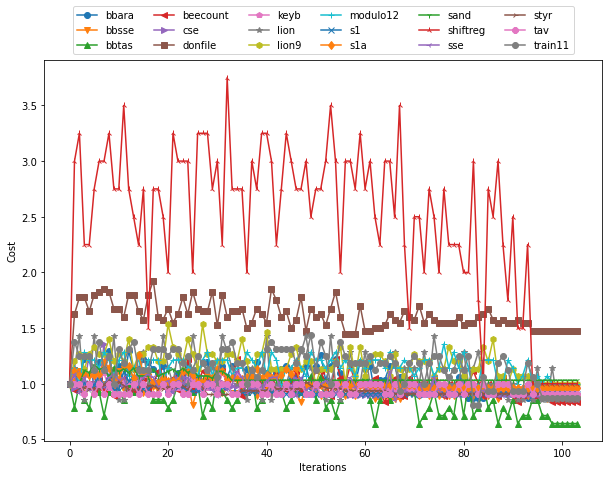

In [20]:
kissfiles = []
for file in glob.glob("msfs/*.kiss2"):
    name = file.split('/')
    name = name[1].split('.')
    kissfiles.append(name[0])
kissfiles.sort()
#kissfiles = ['bbtas']    
print(kissfiles)

with open('resultados2.csv', mode='w') as csv_file:
    fieldnames = ['Caso', 'Custo Inicial', 'Custo Final', 'Percentual', 'Tempo (s)']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    markers = itertools.cycle(['o','v','^','<','>','s','p','*','h','+','x','d','1','2','3','4','8'])
    
    for name in kissfiles:
        temperatura = 100
        custo_init = 0
        custo_final = 0
        valores = []
        temperatura_iter = []
        
        #qt_entradas, qt_saida, qt_estados = get_ready_fsm(name, 'melhor.pla')
    
        tic = time.perf_counter()
        custo_init, custo_final, valores, temperatura_iter = resfriamento_simulado(name, temperatura, 100)
        toc = time.perf_counter()
        tempo = str(toc-tic)
        
        print("Melhor custo:",custo_final)
        print("Tempo de execucao:",toc-tic)
    
        writer.writerow({'Caso': name, 
                         'Custo Inicial': str(custo_init), 
                         'Custo Final': str(custo_final),
                         'Percentual': str(1 - (custo_final/custo_init)),
                         'Tempo (s)': tempo
                        })
        
        for i in range(len(valores)):
            valores[i] = valores[i] / custo_init
            temperatura_iter[i] = temperatura_iter[i] / temperatura
        
        #plt.cla()
        #plt.title('Resultados Normalizados')
        plt.xlabel('Iterations')  # Add an x-label to the axes.
        plt.ylabel('Cost')
        plt.plot(valores, marker=next(markers), label=name)
        
        print(name + ': ok')
        
    #plt.plot(temperatura_iter, '-*', label='Temperatura')    
    plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0., 1.05, 1., .105))
    plt.figure(1)    
    plt.savefig('resultados2.png')